# DQN (2013) 训练 Notebook

本 Notebook 用于训练 DQN 智能体玩 Video Pinball 游戏。

**特性：**
- 实时显示训练进度
- 定期保存检查点
- 强制使用 CUDA

## 0.导入到Google Colab

In [ ]:
# 挂载 Google Drive 保存检查点
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Code/BIT-Embodied-Project/DQN-2013
import os, sys
sys.path.insert(0, os.getcwd())

## 1. 环境检查

In [1]:
import sys
import os
import torch

# 检查 CUDA
if not torch.cuda.is_available():
    raise RuntimeError("CUDA 不可用！请确保已安装 CUDA 版本的 PyTorch。")

# 启用 TF32 加速
torch.set_float32_matmul_precision('high')

print(f"Python: {sys.version}")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA 可用: {torch.cuda.is_available()}")
print(f"CUDA: {torch.version.cuda}")
print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"GPU 内存: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Python: 3.10.19 (main, Oct 21 2025, 16:43:05) [GCC 11.2.0]
PyTorch: 2.9.1+cu128
CUDA 可用: True
CUDA: 12.8
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
GPU 内存: 8.3 GB


## 2. 导入依赖

In [2]:
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
from collections import deque
import time
import imageio

# 添加项目路径
sys.path.insert(0, os.path.dirname(os.path.abspath('')))

from envs import VideoPinballEnv,BreakoutEnv
from envs.wrappers import FrameStack, ClipRewardEnv
from dqn import DQNAgent  # 移除 Transition（不再使用）

## 3. 训练配置

In [3]:
# 训练参数
CONFIG = {
    'total_frames': 30_000_000,     # 总训练帧数
    'log_interval': 10_000,          # 日志输出间隔
    'plot_interval': 50_000,         # 绘图更新间隔
    'eval_interval': 100_000,        # 评估间隔
    'save_interval': 500_000,        # 保存间隔
    'save_dir': 'checkpoints',       # 保存目录
}

print("训练配置:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

训练配置:
  total_frames: 30000000
  log_interval: 10000
  plot_interval: 50000
  eval_interval: 100000
  save_interval: 500000
  save_dir: checkpoints


## 4. 初始化环境和智能体

In [4]:
from gymnasium.vector import AsyncVectorEnv
import multiprocessing as mp

# 使用 spawn 方式创建子进程（避免 CUDA fork 问题）
mp.set_start_method('spawn', force=True)

# 并行环境配置
NUM_ENVS = 8  # 异步环境可以用更多并行度

# 环境工厂函数（必须是可 pickle 的）
def make_env():
    # env = VideoPinballEnv()
    env = BreakoutEnv()
    env = ClipRewardEnv(env)
    env = FrameStack(env, num_stack=4)
    return env

# 创建异步并行环境（真正的多进程并行）
envs = AsyncVectorEnv(
    [make_env for _ in range(NUM_ENVS)],
    shared_memory=True,  # 使用共享内存加速数据传输
)

# 获取动作空间
single_env = make_env()
n_actions = single_env.get_action_space()
single_env.close()
print(f"动作空间: {n_actions}")
print(f"并行环境数: {NUM_ENVS} (AsyncVectorEnv)")

# 创建智能体
agent = DQNAgent(n_actions=n_actions, num_envs=NUM_ENVS, device='cuda', use_compile=False)
print(f"设备: {agent.device}")

os.makedirs(CONFIG['save_dir'], exist_ok=True)

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


动作空间: 4
并行环境数: 8 (AsyncVectorEnv)
设备: cuda


In [5]:
def plot_progress(episode_rewards, losses, frame):
    """Plot training progress"""
    clear_output(wait=True)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    # Reward curve
    ax1 = axes[0]
    if len(episode_rewards) > 0:
        ax1.plot(episode_rewards, alpha=0.3, color='blue', label='Episode')
        # Moving average
        if len(episode_rewards) >= 100:
            window = 100
            avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
            ax1.plot(range(window-1, len(episode_rewards)), avg, color='red', label=f'{window}-ep avg')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward')
    ax1.set_title(f'Training Progress - Frame: {frame:,}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Loss curve
    ax2 = axes[1]
    if len(losses) > 0:
        ax2.plot(losses, alpha=0.5, color='green')
    ax2.set_xlabel('Update Steps')
    ax2.set_ylabel('Loss')
    ax2.set_title('TD Loss')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 5. 性能瓶颈测试

运行 10000 步来分析各部分耗时，找出真正的瓶颈。

In [6]:
import time

def benchmark(agent, envs, num_steps=10000):
    """
    性能瓶颈测试
    
    分析环境交互、经验存储、GPU训练各部分耗时
    """
    t_env = 0      # 环境交互（含动作选择）
    t_select = 0   # 单独的动作选择
    t_step = 0     # 单独的环境 step
    t_store = 0    # 存储经验
    t_train = 0    # GPU 训练
    
    # 重置环境
    states, _ = envs.reset()
    agent.frame_count = agent.warmup_frames + 1  # 跳过预热期
    
    # 预填充 replay buffer（使用新的单帧存储接口）
    print("预填充 replay buffer...")
    for _ in range(agent.batch_size * 2):
        actions = agent.select_actions_batch(states)
        next_states, rewards, terminateds, truncateds, _ = envs.step(actions)
        dones = terminateds | truncateds
        for i in range(NUM_ENVS):
            # 提取最后一帧存储（新接口）
            frame = states[i][-1]  # (4, 84, 84) -> (84, 84)
            agent.store_transition(frame, actions[i], rewards[i], dones[i], env_id=i)
        states = next_states
    
    print(f"开始性能测试 ({num_steps} steps, {NUM_ENVS} 并行环境)...\n")
    
    # 同步 GPU
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    start_time = time.perf_counter()
    
    for step in range(num_steps):
        # 动作选择
        t0 = time.perf_counter()
        actions = agent.select_actions_batch(states)
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        t_select += time.perf_counter() - t0
        
        # 环境 step
        t0 = time.perf_counter()
        next_states, rewards, terminateds, truncateds, _ = envs.step(actions)
        dones = terminateds | truncateds
        t_step += time.perf_counter() - t0
        
        # 存储经验（新接口：单帧存储）
        t0 = time.perf_counter()
        for i in range(NUM_ENVS):
            frame = states[i][-1]  # 提取最后一帧
            agent.store_transition(frame, actions[i], rewards[i], dones[i], env_id=i)
        t_store += time.perf_counter() - t0
        
        # GPU 训练
        t0 = time.perf_counter()
        agent.update()
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        t_train += time.perf_counter() - t0
        
        states = next_states
    
    total_time = time.perf_counter() - start_time
    total_frames = num_steps * NUM_ENVS
    
    # 打印结果
    print("=" * 50)
    print("性能测试结果")
    print("=" * 50)
    print(f"总耗时:     {total_time:.2f}s")
    print(f"总帧数:     {total_frames:,}")
    print(f"FPS:        {total_frames / total_time:.0f}")
    print()
    print("各部分耗时:")
    print("-" * 50)
    t_env = t_select + t_step
    measured = t_env + t_store + t_train
    print(f"  动作选择:   {t_select:6.2f}s  ({t_select/measured*100:5.1f}%)")
    print(f"  环境 step:  {t_step:6.2f}s  ({t_step/measured*100:5.1f}%)")
    print(f"  存储经验:   {t_store:6.2f}s  ({t_store/measured*100:5.1f}%)")
    print(f"  GPU 训练:   {t_train:6.2f}s  ({t_train/measured*100:5.1f}%)")
    print("-" * 50)
    print(f"  合计测量:   {measured:6.2f}s")
    print(f"  其他开销:   {total_time - measured:6.2f}s")
    print()
    
    # 瓶颈判断
    bottleneck = max([("动作选择", t_select), ("环境 step", t_step), 
                      ("存储经验", t_store), ("GPU 训练", t_train)], key=lambda x: x[1])
    print(f"主要瓶颈: {bottleneck[0]} ({bottleneck[1]/measured*100:.1f}%)")
    
    return {
        "total_time": total_time,
        "fps": total_frames / total_time,
        "t_select": t_select,
        "t_step": t_step,
        "t_store": t_store,
        "t_train": t_train,
    }

# 运行测试
benchmark_result = benchmark(agent, envs, num_steps=10000)

预填充 replay buffer...
开始性能测试 (10000 steps, 8 并行环境)...

性能测试结果
总耗时:     469.85s
总帧数:     80,000
FPS:        170

各部分耗时:
--------------------------------------------------
  动作选择:     3.45s  (  0.7%)
  环境 step:   16.59s  (  3.5%)
  存储经验:     0.67s  (  0.1%)
  GPU 训练:   449.12s  ( 95.6%)
--------------------------------------------------
  合计测量:   469.83s
  其他开销:     0.02s

主要瓶颈: GPU 训练 (95.6%)


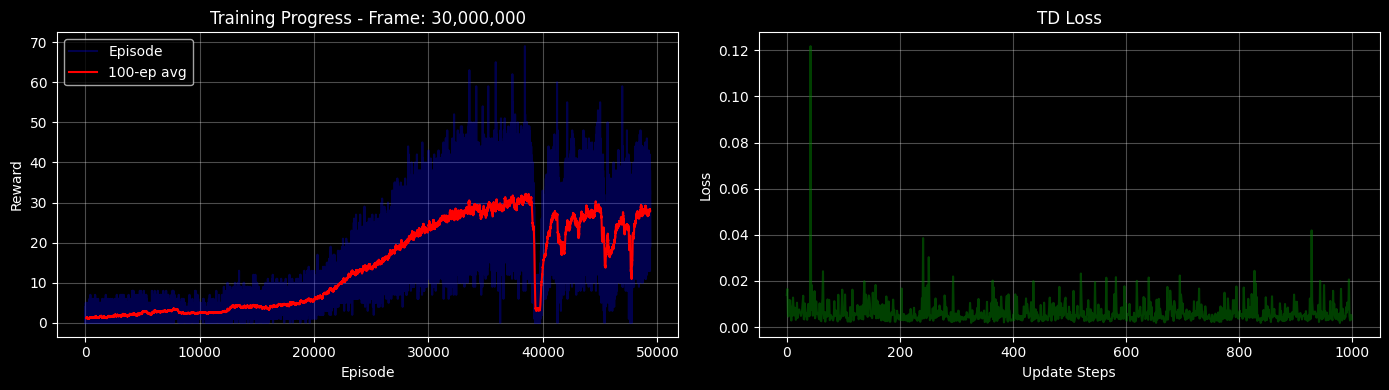

帧: 30,000,000 | 回合: 49370 | 平均奖励(100): 27.94 | epsilon: 0.100 | FPS: 205

训练完成！最佳平均奖励: 31.96


In [7]:
# 统计数据
episode_rewards = []
losses = []
episode_rewards_buffer = [0.0] * NUM_ENVS
episode_count = 0
best_avg_reward = float('-inf')  # 跟踪最高平均奖励
states, _ = envs.reset()  # gymnasium 新版返回 (obs, info)
start_time = time.time()

print("开始训练...")

for step in range(1, CONFIG['total_frames'] // NUM_ENVS + 1):
    frame = step * NUM_ENVS
    agent.frame_count = frame
    
    # 批量选择动作
    actions = agent.select_actions_batch(states)
    
    # 执行动作 (gymnasium 新版返回 5 个值)
    next_states, rewards, terminateds, truncateds, infos = envs.step(actions)
    dones = terminateds | truncateds
    
    # 为每个环境存储经验（单帧存储，符合原始论文）
    for i in range(NUM_ENVS):
        # 从堆叠状态中提取最后一帧
        current_frame = states[i][-1]  # (4, 84, 84) -> (84, 84)
        agent.store_transition(current_frame, actions[i], rewards[i], dones[i], env_id=i)
        episode_rewards_buffer[i] += rewards[i]
        
        if dones[i]:
            episode_rewards.append(episode_rewards_buffer[i])
            episode_count += 1
            episode_rewards_buffer[i] = 0.0
    
    # 训练更新
    loss = agent.update()
    if loss is not None:
        losses.append(loss)
    
    states = next_states
    
    # 日志
    if frame % CONFIG['plot_interval'] == 0:
        elapsed = time.time() - start_time
        fps = frame / elapsed
        plot_progress(episode_rewards, losses[-1000:], frame)
        
        current_avg = np.mean(episode_rewards[-100:]) if episode_rewards else 0
        print(f"帧: {frame:,} | 回合: {episode_count} | "
              f"平均奖励(100): {current_avg:.2f} | "
              f"epsilon: {agent.get_epsilon():.3f} | FPS: {fps:.0f}")
        
        # 保存最佳模型
        if len(episode_rewards) >= 100 and current_avg > best_avg_reward:
            best_avg_reward = current_avg
            agent.save(os.path.join(CONFIG['save_dir'], 'dqn_best.pt'))
            print(f"  -> 新最高分！已保存模型 (avg: {best_avg_reward:.2f})")

envs.close()
print(f"\n训练完成！最佳平均奖励: {best_avg_reward:.2f}")

## 6. 查看最终结果

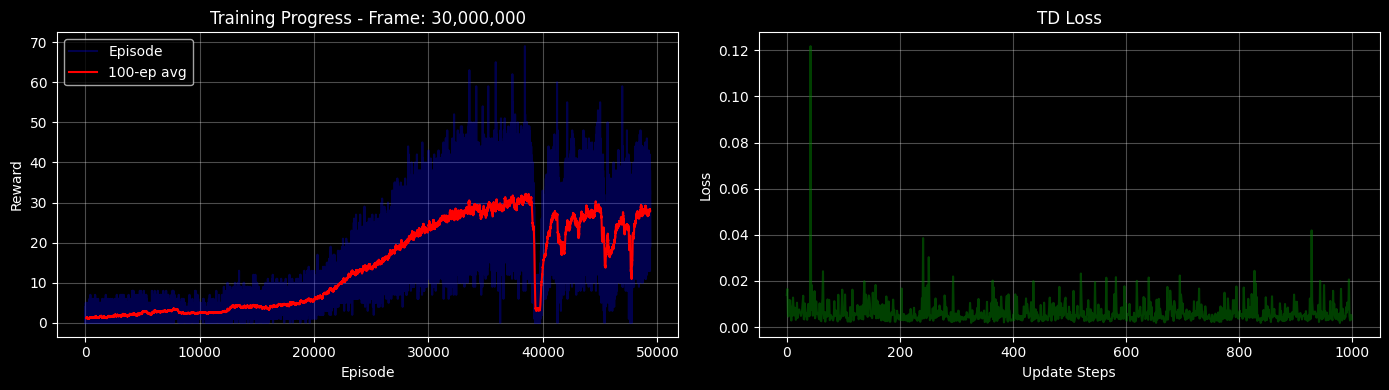


训练统计:
  总回合数: 49370
  最高奖励: 69.00
  最终 100 回合平均: 27.94


In [8]:
# 最终训练曲线
plot_progress(episode_rewards, losses[-1000:], CONFIG['total_frames'])

print(f"\n训练统计:")
print(f"  总回合数: {len(episode_rewards)}")
print(f"  最高奖励: {max(episode_rewards) if episode_rewards else 0:.2f}")
print(f"  最终 100 回合平均: {np.mean(episode_rewards[-100:]) if episode_rewards else 0:.2f}")

## 7. 评估训练好的智能体

In [10]:
def evaluate(agent, n_episodes=10, save_video=True, video_dir='videos'):
    """评估智能体，可选保存视频"""
    # eval_env = VideoPinballEnv(render_mode='rgb_array' if save_video else None)
    eval_env = BreakoutEnv(render_mode='rgb_array' if save_video else None)
    eval_env = ClipRewardEnv(eval_env)
    eval_env = FrameStack(eval_env, num_stack=4)
    
    if save_video:
        os.makedirs(video_dir, exist_ok=True)
    
    rewards = []
    for ep in range(n_episodes):
        state, _ = eval_env.reset()
        total = 0
        done = False
        frames = []
        
        while not done:
            if save_video:
                frames.append(eval_env.unwrapped.ale.getScreenRGB())
            
            action = agent.select_action(state, eval_mode=True)
            state, reward, terminated, truncated,_ = eval_env.step(action)
            done = terminated or truncated
            total += reward
        
        rewards.append(total)
        print(f"  回合 {ep+1}: {total:.2f}")
        
        if save_video and frames:
            video_path = os.path.join(video_dir, f'episode_{ep+1}.mp4')
            imageio.mimsave(video_path, frames, fps=30, macro_block_size=1)
            print(f"    视频已保存: {video_path}")
    
    eval_env.close()
    return np.mean(rewards), np.std(rewards)

print("评估中...")
mean_reward, std_reward = evaluate(agent, n_episodes=10, save_video=True)
print(f"\n评估结果: {mean_reward:.2f} ± {std_reward:.2f}")

评估中...
  回合 1: 23.00
    视频已保存: videos/episode_1.mp4
  回合 2: 32.00
    视频已保存: videos/episode_2.mp4
  回合 3: 20.00
    视频已保存: videos/episode_3.mp4
  回合 4: 29.00
    视频已保存: videos/episode_4.mp4
  回合 5: 32.00
    视频已保存: videos/episode_5.mp4
  回合 6: 32.00
    视频已保存: videos/episode_6.mp4
  回合 7: 31.00
    视频已保存: videos/episode_7.mp4
  回合 8: 23.00
    视频已保存: videos/episode_8.mp4
  回合 9: 20.00
    视频已保存: videos/episode_9.mp4
  回合 10: 34.00
    视频已保存: videos/episode_10.mp4

评估结果: 27.60 ± 5.20
